# Model selection using refnx and dynesty

refnx + dynesty can be used to obtain the Bayesian evidence, which allows you to perform model selection.

In [1]:
%matplotlib inline
import numpy as np
import dynesty

from refnx.analysis import Objective, Model, Parameter, Parameters
from refnx.dataset import Data1D
import matplotlib.pyplot as plt

In [2]:
def gauss(x, p):
    A, loc, sd = p
    y = A * np.exp(-((x - loc) / sd)**2)

    return y

We'll synthesise some experimental data from two Gaussians with a linear background. We'll also add on some noise.

In [3]:
x = np.linspace(3, 7, 250)
rng = np.random.default_rng(0)

y = 4 + 10 * x + gauss(x, [200, 5, 0.5]) + gauss(x, [60, 5.8, 0.2])
dy = np.sqrt(y)
y += dy * rng.normal(size=np.size(y))

data = Data1D((x, y, dy))

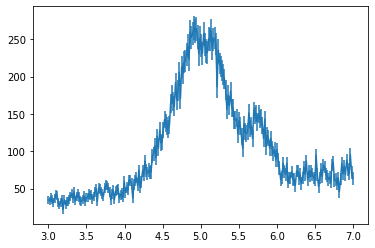

In [4]:
data.plot();

In [5]:
# this is our model that we want to fit.
# It will have a linear background and a number of Gaussian peaks
# The parameters for the background and each of the Gaussian peaks
# will be held in separate entries in `p`.
def n_gauss(x, p):
    y = np.zeros_like(x)
    
    # background parameters
    a, b = np.array(p[0])
    y += a + b*x
    
    for i in range(1, len(p)):
        g_pars = p[i]
        A, loc, sd = np.array(g_pars)
        y += gauss(x, [A, loc, sd])
    return y

In [6]:
# the overall parameter set
pars = Parameters(name="overall_parameters")

# parameters for the background
bkg_pars = Parameters(name='bkg')  
intercept = Parameter(1, name='intercept', bounds=(0, 200), vary=True)
gradient = Parameter(1, name='gradient', bounds=(-20, 250), vary=True)
bkg_pars.extend([intercept, gradient])

pars.append(bkg_pars)

# now go through and add in gaussian peaks and calculate the log-evidence
model = Model(pars, n_gauss)
logz = []
for i in range(4):
    if i:
        A = Parameter(5, name=f"A{i}", bounds=(40, 250), vary=True)
        loc = Parameter(5, name=f"loc{i}", bounds=(3, 7), vary=True)
        sd = Parameter(5, name=f"sd{i}", bounds=(0.1, 2), vary=True)
        g_pars = Parameters(data=[A, loc, sd], name=f"gauss{i}")
        
        pars.append(g_pars)
    
    objective = Objective(model, data)
    nested_sampler = dynesty.NestedSampler(
        objective.logl,
        objective.prior_transform,
        ndim=len(pars.varying_parameters())
    )
    nested_sampler.run_nested()
    logz.append(nested_sampler.results.logz[-1])

5907it [00:05, 1075.69it/s, +500 | bound: 14 | nc: 1 | ncall: 28160 | eff(%): 22.752 | loglstar:   -inf < -4233.325 <    inf | logz: -4244.268 +/-  0.198 | dlogz:  0.001 >  0.509]
12557it [00:18, 696.48it/s, +500 | bound: 48 | nc: 1 | ncall: 53297 | eff(%): 24.499 | loglstar:   -inf < -1048.585 <    inf | logz: -1072.989 +/-  0.313 | dlogz:  0.001 >  0.509]
17403it [11:47, 24.60it/s, +500 | bound: 2186 | nc: 1 | ncall: 1701762 | eff(%):  1.052 | loglstar:   -inf < -913.031 <    inf | logz: -947.230 +/-  0.372 | dlogz:  0.001 >  0.509]
19222it [02:40, 119.67it/s, +500 | bound: 261 | nc: 1 | ncall: 461894 | eff(%):  4.270 | loglstar:   -inf < -911.813 <    inf | logz: -949.640 +/-  0.392 | dlogz:  0.001 >  0.509]


In [7]:
print(logz)

[-4244.267669942061, -1072.989448001302, -947.2295781758878, -949.6400447012933]


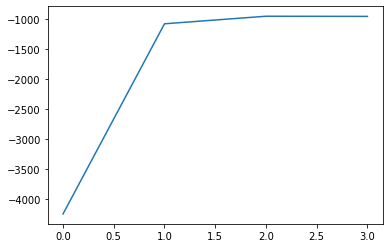

In [8]:
plt.plot(logz)

The log-evidence points to the use of 2 Gaussians to fit the data. There is a sufficient increase in evidence over 1 Gaussian. However, 3 Gaussians is not justified, the logz term does not increase.